In [1]:
import sys

sys.path.append("..")

%load_ext autoreload
%autoreload complete

In [2]:
from math import ceil
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import regionmask
import dask
import xarray as xr

from lmrecon.io import IntakeESMLoader, CESMTimeseriesLoader
from lmrecon.plotting import plot_field
from lmrecon.units import convert_thetaot_to_ohc
from lmrecon.grid import GLOBAL_GRID, get_z_from_hybrid_coordinate
from lmrecon.util import stack_state
from lmrecon.stats import average_annually, average_seasonally, area_weighted_mean, rmse
from lmrecon.time import add_season_coords

In [6]:
from dask.distributed import Client

client = Client(n_workers=dask.system.CPU_COUNT // 2, threads_per_worker=1)

2025-02-17 17:16:50    INFO State start
2025-02-17 17:16:50    INFO   Scheduler at:     tcp://127.0.0.1:34403
2025-02-17 17:16:50    INFO   dashboard at:  https://jupyterhub.hpc.ucar.edu/stable/user/dstiller/proxy/36019/status
2025-02-17 17:16:50    INFO Registering Worker plugin shuffle
2025-02-17 17:16:50    INFO         Start Nanny at: 'tcp://127.0.0.1:43113'
2025-02-17 17:16:50    INFO         Start Nanny at: 'tcp://127.0.0.1:33999'
2025-02-17 17:16:56    INFO Register worker addr: tcp://127.0.0.1:43353 name: 0
2025-02-17 17:16:56    INFO Starting worker compute stream, tcp://127.0.0.1:43353
2025-02-17 17:16:56    INFO Starting established connection to tcp://127.0.0.1:49896
2025-02-17 17:16:56    INFO Register worker addr: tcp://127.0.0.1:42895 name: 1
2025-02-17 17:16:56    INFO Starting worker compute stream, tcp://127.0.0.1:42895
2025-02-17 17:16:56    INFO Starting established connection to tcp://127.0.0.1:49892
2025-02-17 17:16:56    INFO Receive client connection: Client-a63

In [7]:
# loader = IntakeESMLoader("CESM2", "piControl", ["cldhigh"])
# ds = loader.load_dataset("000101-009912")
# loader = IntakeESMLoader("MIROC-ES2L", "past1000", ["ohc700"])
# ds = loader.load_dataset(["085001-104912", "105001-124912"])
# ds = loader.load_dataset(["105001-124912"])
loader = IntakeESMLoader("MPI-ESM1-2-LR", "past2k", ["tas"])
ds = loader.load_dataset()
# ds = loader.load_dataset(["700101-702012"])
# loader = IntakeESMLoader("MRI-ESM2-0", "past1000", ["tas"])
# ds = loader.load_dataset(["085001-089912"])
ds

2025-02-18 19:22:06   DEBUG Opening catalog /home/enkf6/dstiller/CMIP6/catalog.json
2025-02-18 19:22:07    INFO Loading dataset for MPI-ESM1-2-LR past2k, member r1i1p1f1
2025-02-18 19:22:07   DEBUG  - CMIP6Variable(name='tas', id='tas', table='Amon')


<xarray.Dataset> Size: 1GB
Dimensions:  (time: 22200, lat: 90, lon: 180)
Coordinates:
  * time     (time) object 178kB 7001-01-16 12:00:00 ... 8850-12-16 12:00:00
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Data variables:
    tas      (time, lat, lon) float32 1GB dask.array<chunksize=(240, 90, 180), meta=np.ndarray>

In [11]:
average_seasonally(ds).chunk(dict(time=200))

<xarray.Dataset> Size: 959MB
Dimensions:  (time: 7399, lat: 90, lon: 180)
Coordinates:
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * time     (time) float64 59kB 7.001e+03 7.002e+03 ... 8.851e+03 8.851e+03
Data variables:
    tas      (time, lat, lon) float64 959MB dask.array<chunksize=(200, 90, 180), meta=np.ndarray>

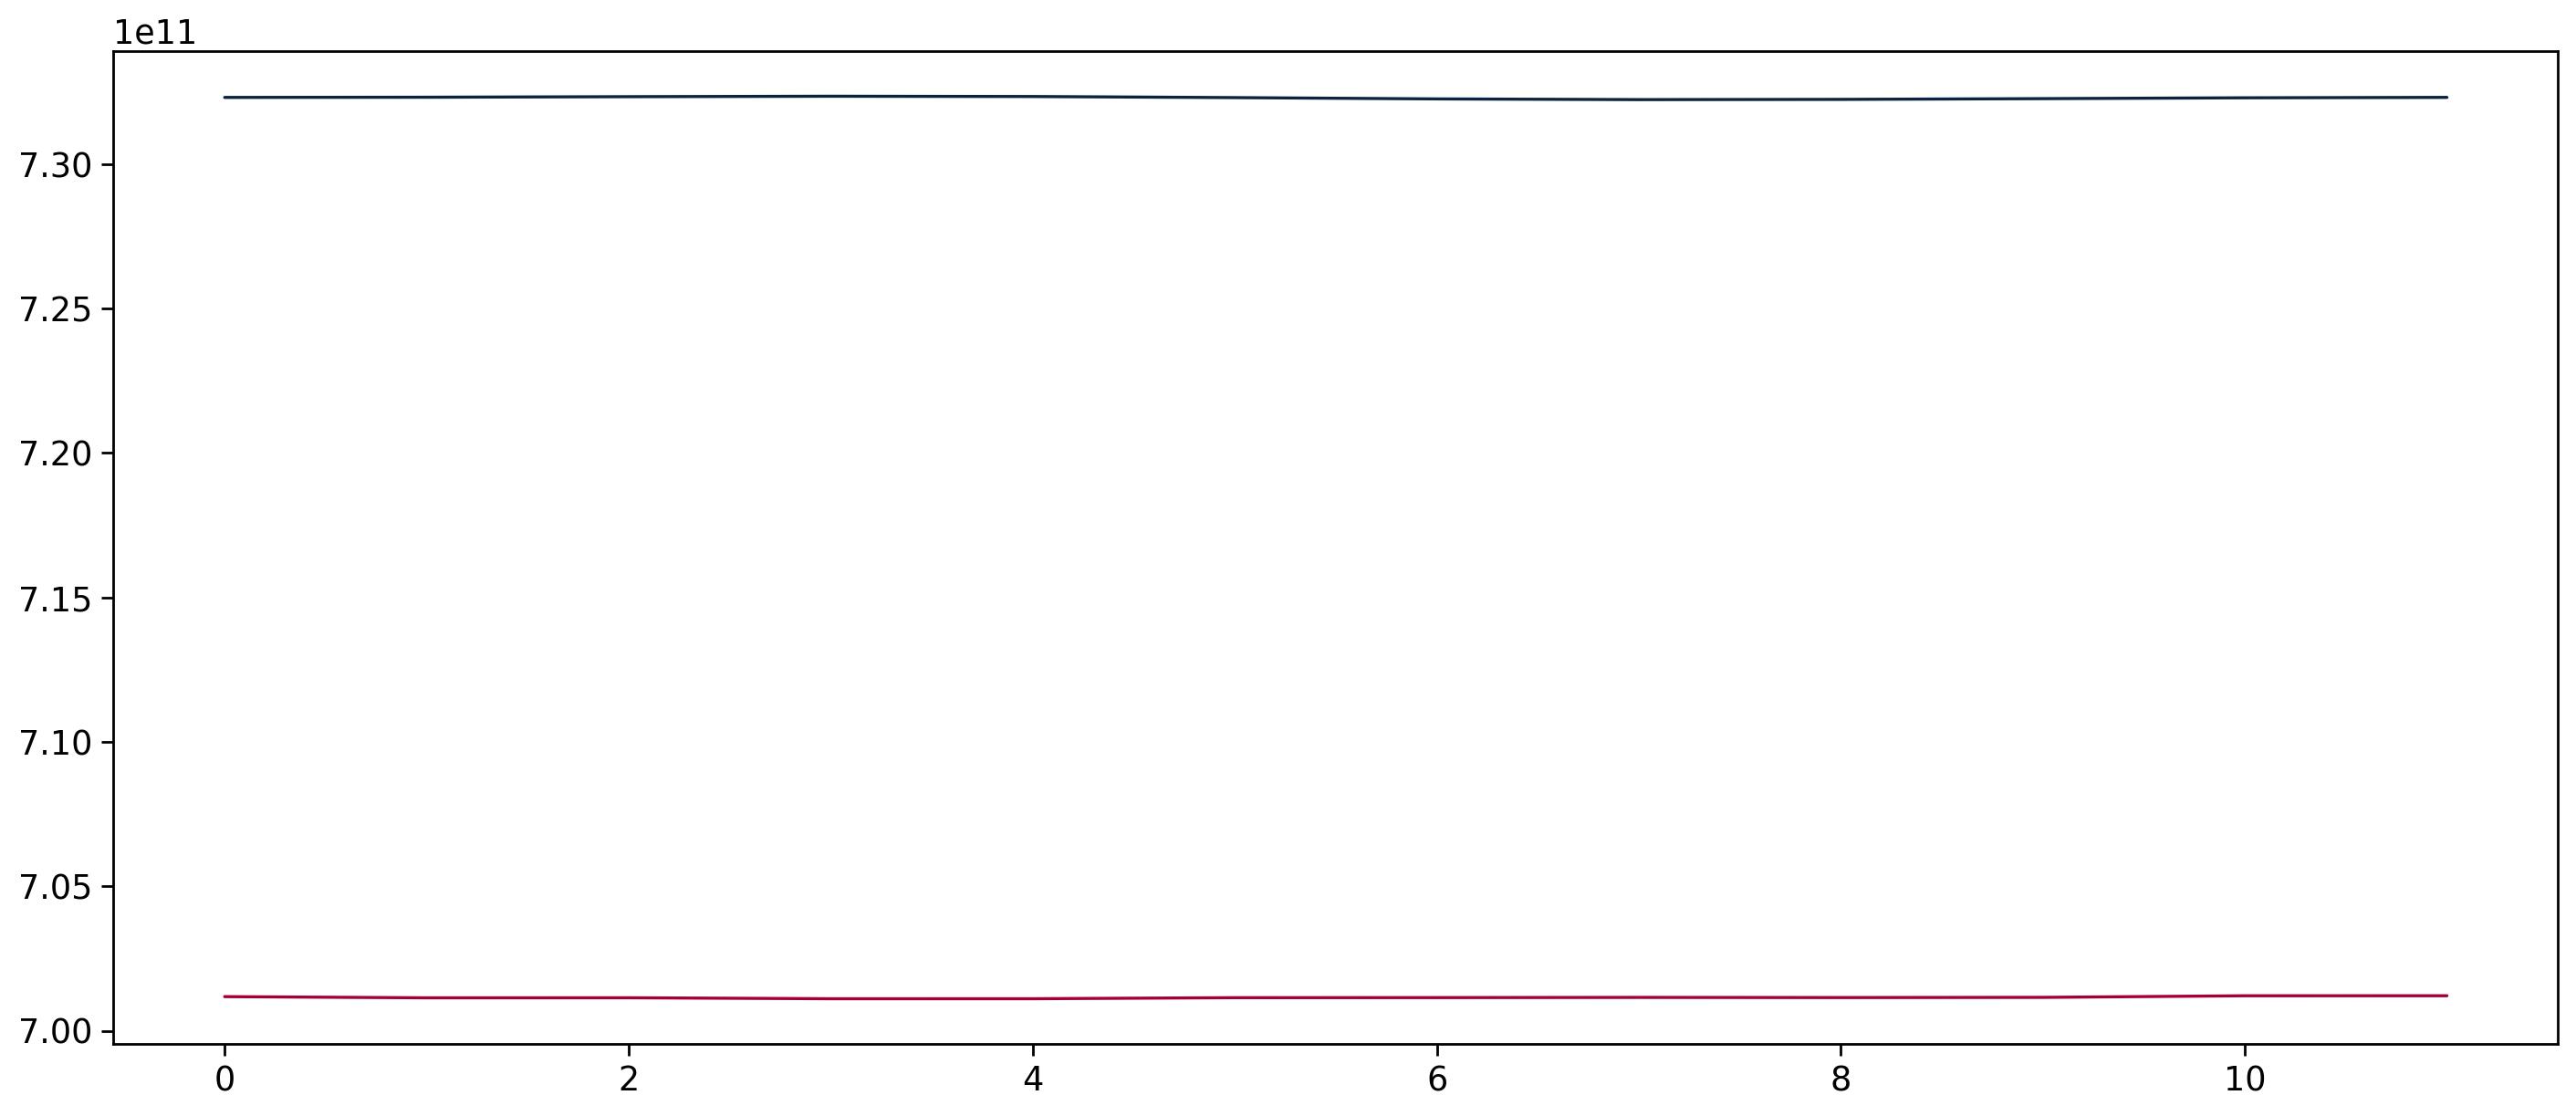

In [48]:
plt.plot(area_weighted_mean(ds["ohc700"]))
plt.plot(area_weighted_mean(ds2["ohc700"]))

In [12]:
ds1 = xr.open_mfdataset("/glade/campaign/univ/uwas0141/CMIP6/PMIP/MIROC/MIROC-ES2L/past1000/r1i1p1f2/Omon/thetao/gn/v20200318/*.nc")
# ds1 = ds1.isel(time=slice(5))
# thetao = ds1["thetao"].assign_coords(lev=get_z_from_hybrid_coordinate(ds1))
ds1

<xarray.Dataset> Size: 323GB
Dimensions:             (time: 12000, bnds: 2, lev: 63, y: 256, x: 360,
                         vertices: 4)
Coordinates:
  * time                (time) object 96kB 0850-01-16 12:00:00 ... 1849-12-16...
  * lev                 (lev) float64 504B 1.0 3.5 7.0 ... 6.87e+03 7.25e+03
  * y                   (y) float64 2kB -88.0 -85.75 -85.25 ... 150.5 152.4
  * x                   (x) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    latitude            (y, x) float32 369kB dask.array<chunksize=(256, 360), meta=np.ndarray>
    longitude           (y, x) float32 369kB dask.array<chunksize=(256, 360), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables: (12/15)
    time_bnds           (time, bnds) object 192kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    lev_bnds            (time, lev, bnds) float64 12MB dask.array<chunksize=(2400, 63, 2), meta=np.ndarray>
    sigma               (time, lev) float64 6MB dask.array<chunksize=(2400, 63), meta=np.ndarray>
    eta                 (time, y, x) float32 4GB dask.array<chunksize=(1, 256, 360), meta=np.ndarray>
    depth               (time, y, x) float32 4GB dask.array<chunksize=(2400, 256, 360), meta=np.ndarray>
    depth_c             (time) float64 96kB 50.0 50.0 50.0 ... 50.0 50.0 50.0
    ...                  ...
    zlev_bnds           (time, lev, bnds) float64 12MB dask.array<chunksize=(2400, 63, 2), meta=np.ndarray>
    y_bnds              (time, y, bnds) float64 49MB dask.array<chunksize=(2400, 256, 2), meta=np.ndarray>
    x_bnds              (time, x, bnds) float64 69MB dask.array<chunksize=(2400, 360, 2), meta=np.ndarray>
    vertices_latitude   (time, y, x, vertices) float32 18GB dask.array<chunksize=(2400, 256, 360, 4), meta=np.ndarray>
    vertices_longitude  (time, y, x, vertices) float32 18GB dask.array<chunksize=(2400, 256, 360, 4), meta=np.ndarray>
    thetao              (time, lev, y, x) float32 279GB dask.array<chunksize=(1, 32, 128, 180), meta=np.ndarray>
Attributes: (12/38)
    Conventions:           CF-1.7 CMIP-6.2
    activity_id:           PMIP
    branch_method:         no parent
    creation_date:         2020-02-20T00:56:05Z
    data_specs_version:    01.00.28
    experiment:            last millennium
    ...                    ...
    title:                 MIROC-ES2L output prepared for CMIP6
    variable_id:           thetao
    variant_label:         r1i1p1f2
    license:               CMIP6 model data produced by MIROC is licensed und...
    cmor_version:          3.3.2
    tracking_id:           hdl:21.14100/73b77c9a-f9af-4b3e-a183-107b53dff741

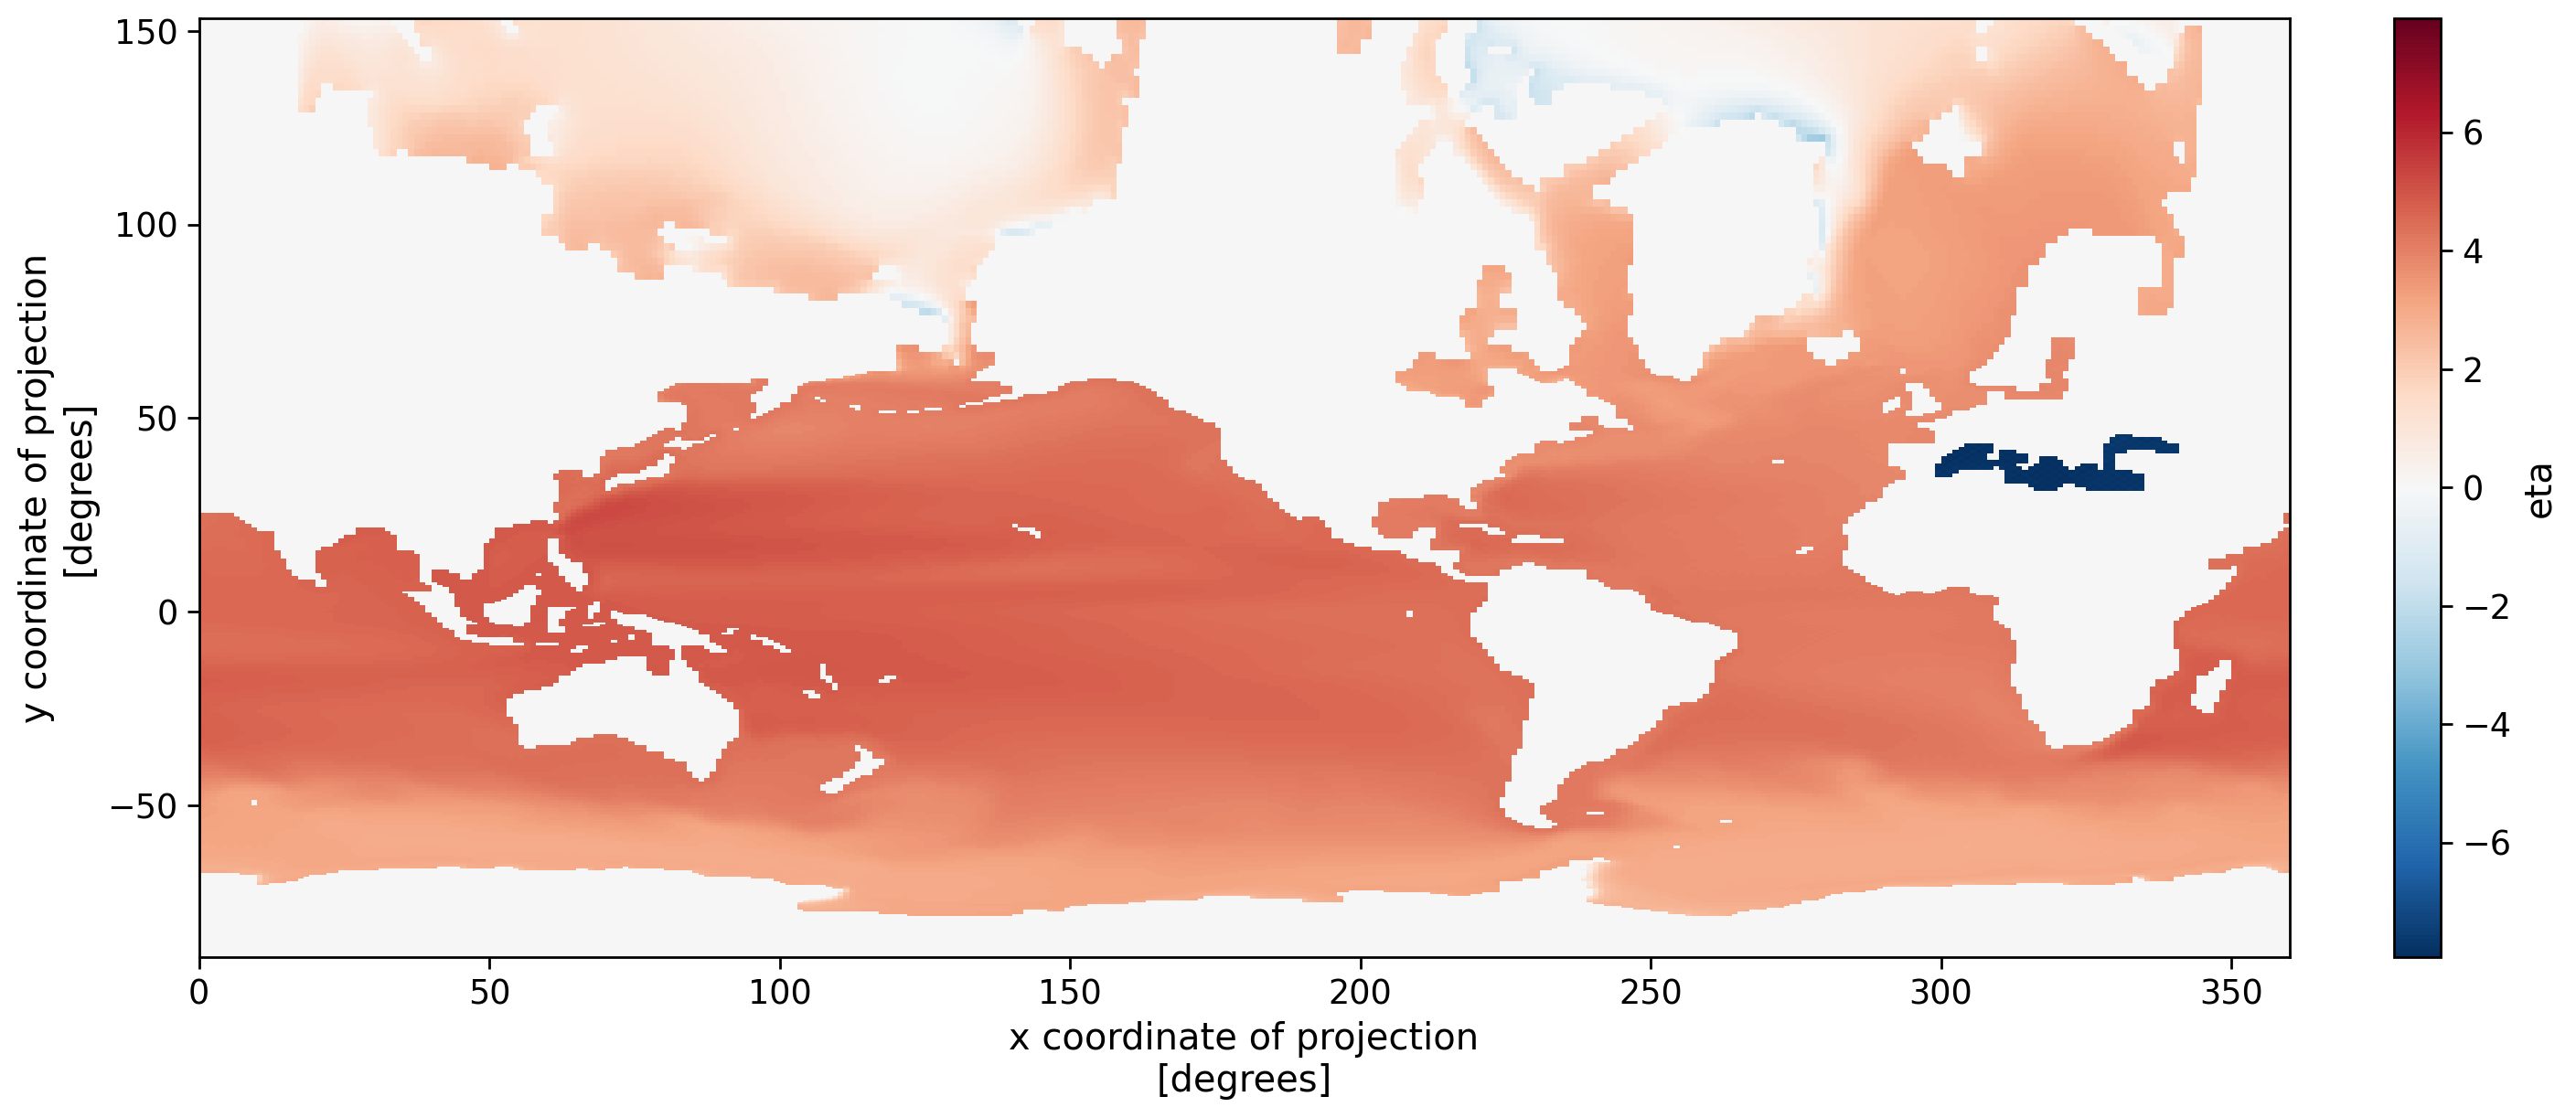

In [29]:
ds1["eta"].isel(time=slice(5*12)).mean("time").plot()

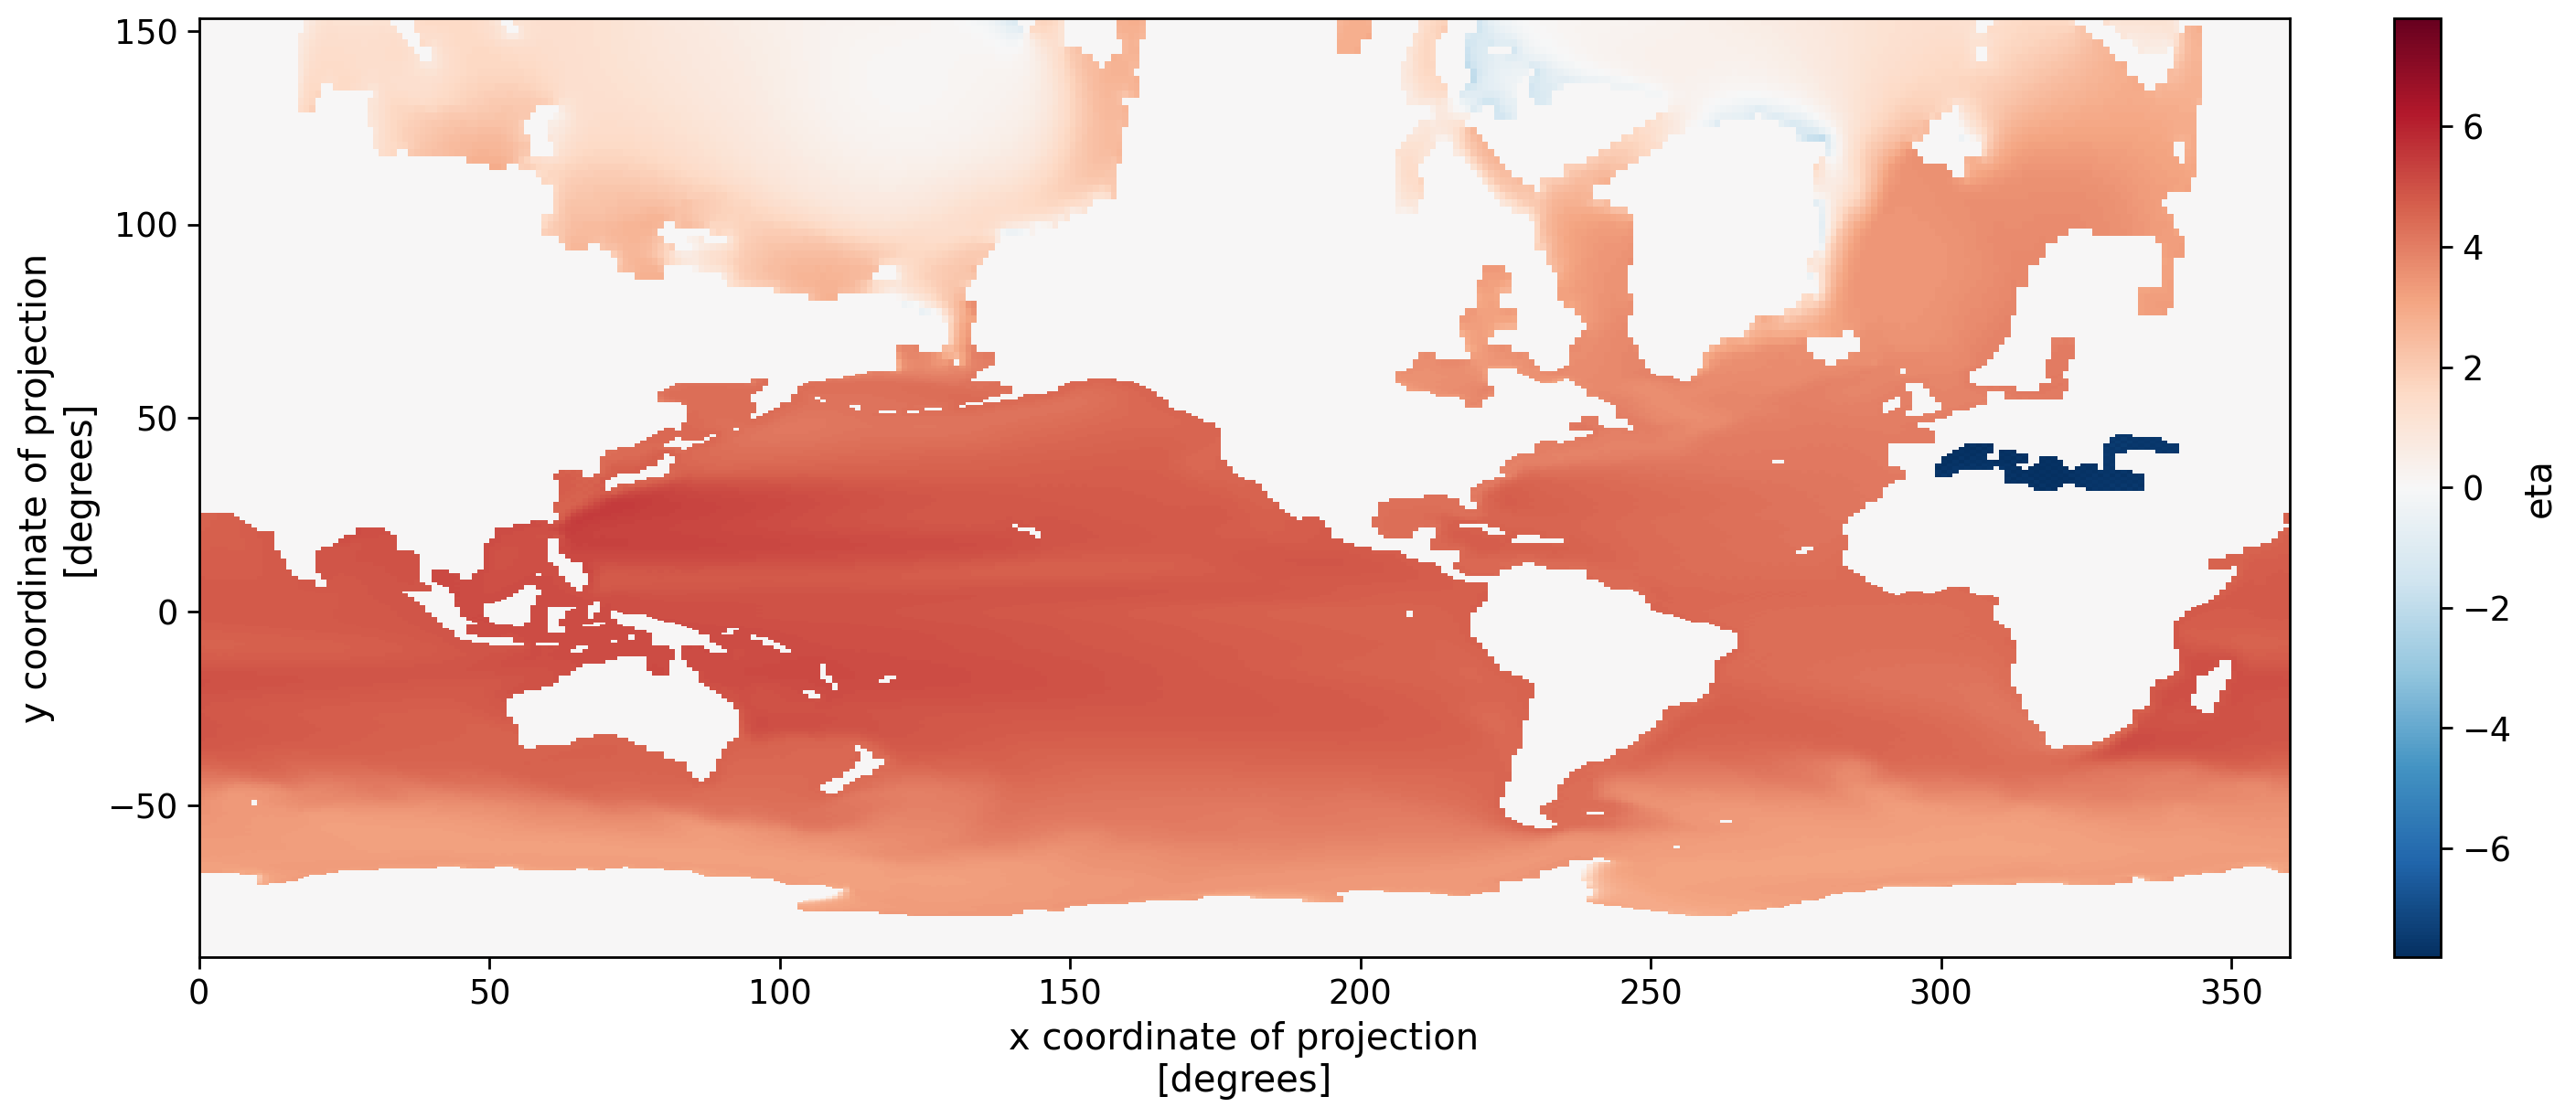

In [28]:
ds1["eta"].mean("time").plot()

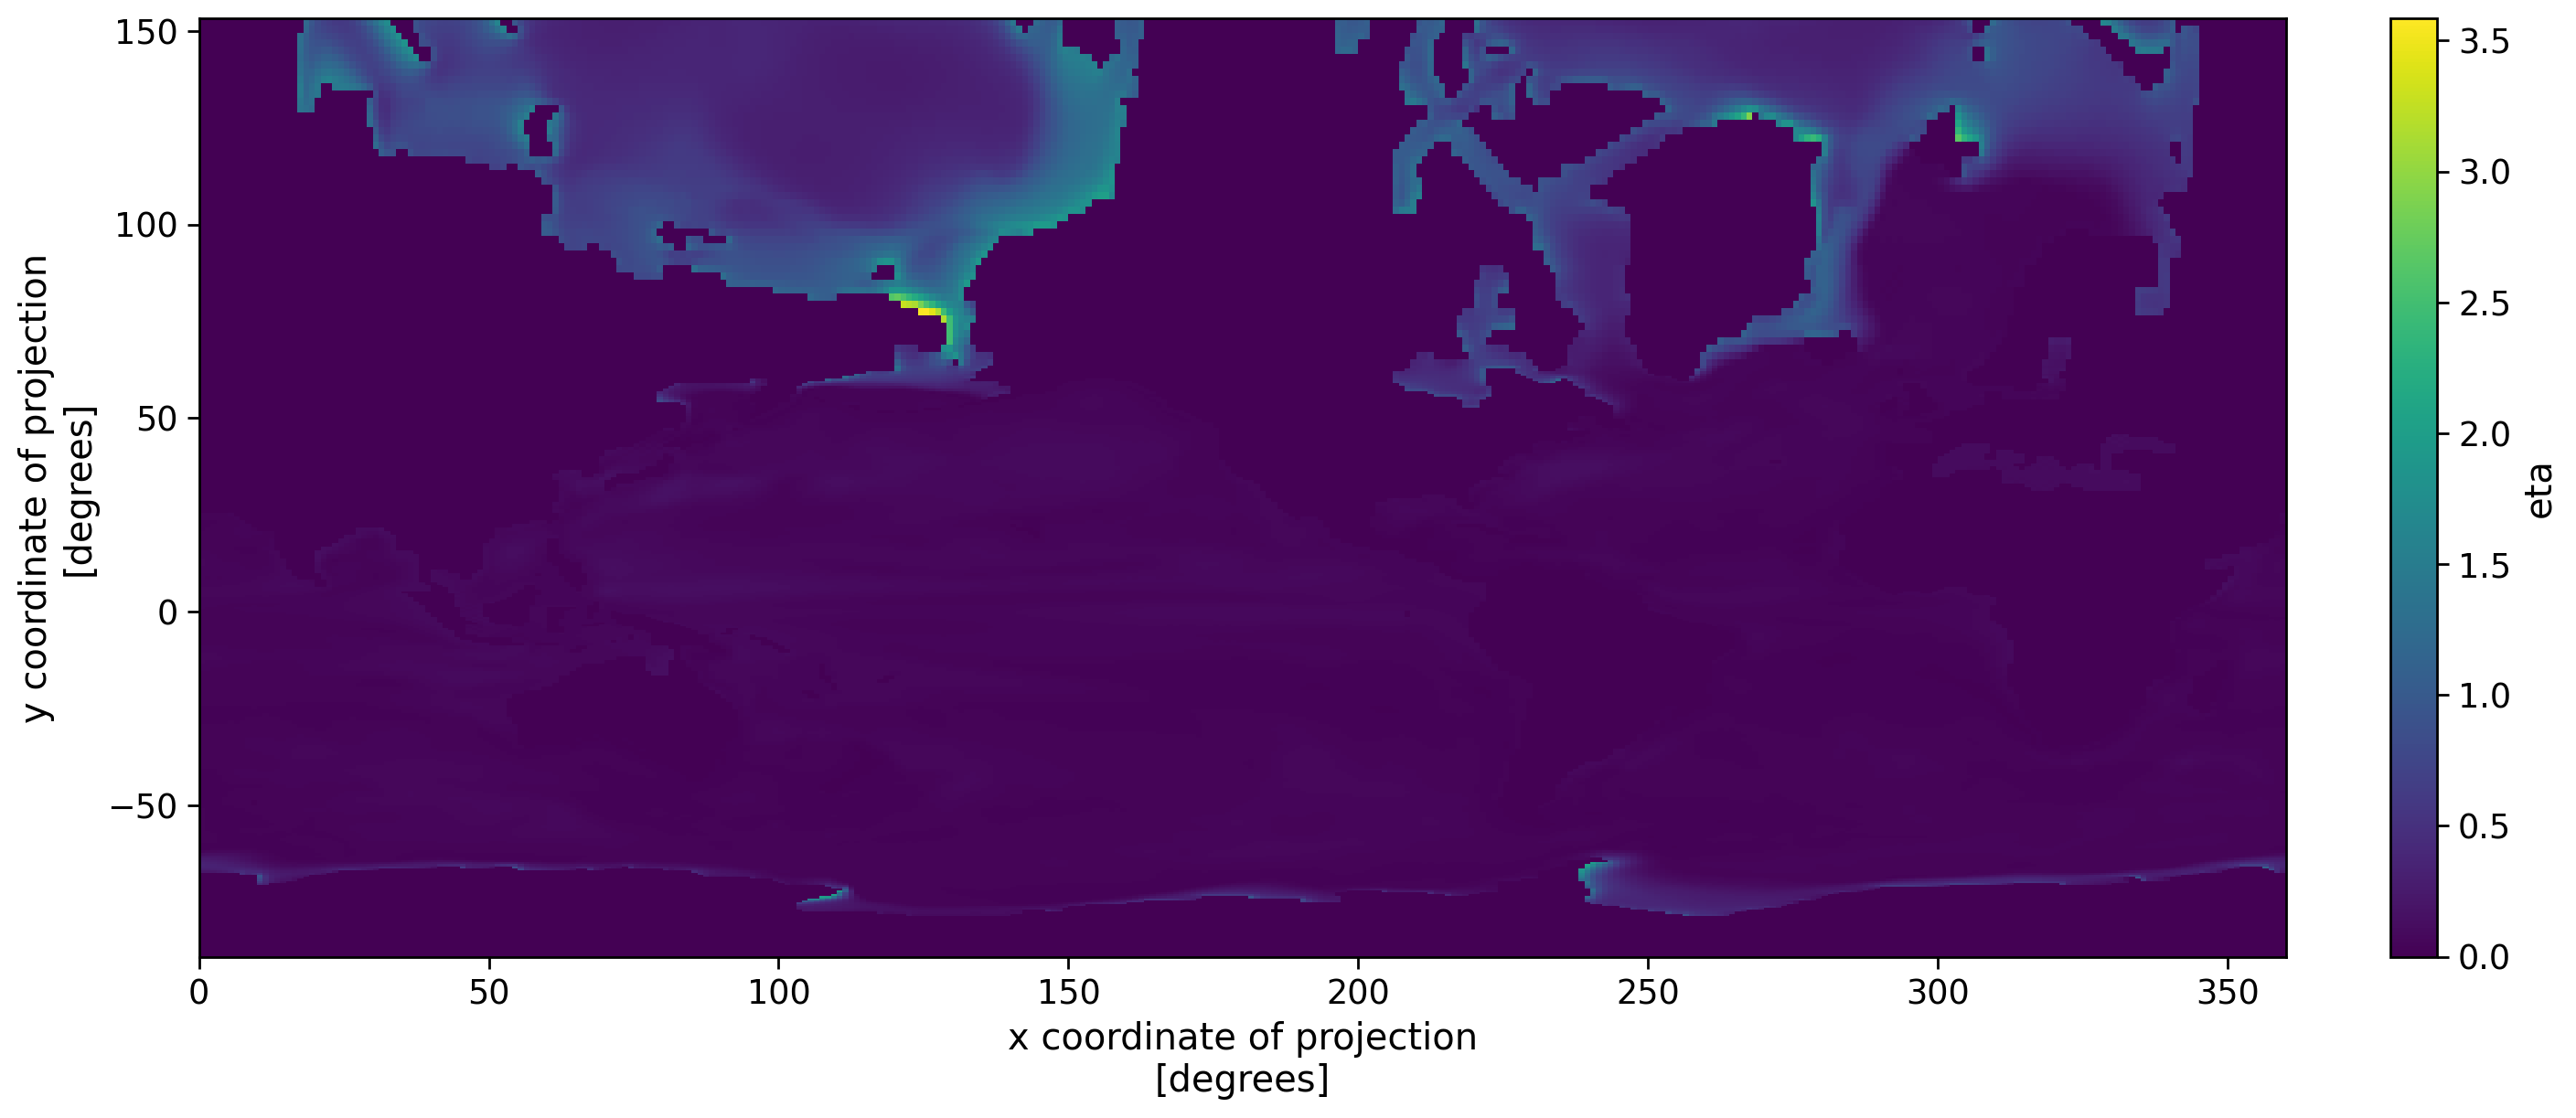

In [22]:
ds1["eta"].isel(time=slice(5*12)).std("time").plot()

In [17]:
get_ocean_sigma_z_from_hybrid_coordinate(ds1, bounds=True)

<xarray.DataArray 'lev_bnds' (time: 12000, lev: 63, bnds: 2, y: 256, x: 360)> Size: 1TB
dask.array<neg, shape=(12000, 63, 2, 256, 360), dtype=float64, chunksize=(1, 53, 2, 256, 360), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 96kB 0850-01-16 12:00:00 ... 1849-12-16 12:00:00
  * lev        (lev) float64 504B 1.0 3.5 7.0 ... 6.24e+03 6.87e+03 7.25e+03
  * y          (y) float64 2kB -88.0 -85.75 -85.25 -84.75 ... 148.6 150.5 152.4
  * x          (x) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    latitude   (y, x) float32 369kB dask.array<chunksize=(256, 360), meta=np.ndarray>
    longitude  (y, x) float32 369kB dask.array<chunksize=(256, 360), meta=np.ndarray>
Dimensions without coordinates: bnds
Attributes:
    long_name:  vertical coordinate formula term: zlev(k+1/2)

In [53]:
loader = CESMTimeseriesLoader("/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.BWmaHIST.f19_g17.CMIP6-historical-WACCM-MA-2deg.003", ["tos"])
ds = loader.load_dataset()
ds

2025-02-17 14:12:29   DEBUG  - CESMVariable(name='tos', id='SST', component='ocn')
2025-02-17 14:12:29    INFO Using daily data for SST


TypeError: 'NoneType' object is not callable

In [8]:
ds_annual = average_annually(ds)
ds_annual

In [15]:
ds_seasonal = average_seasonally(ds)
ds_seasonal

<xarray.Dataset> Size: 77MB
Dimensions:  (time: 79, lat: 90, lon: 180)
Coordinates:
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * time     (time) float64 632B 7.001e+03 7.002e+03 ... 7.021e+03 7.021e+03
    season   (time) object 632B Season.MAM Season.JJA ... Season.JJA Season.SON
Data variables: (12/14)
    cldhigh  (time, lat, lon) float32 5MB dask.array<chunksize=(79, 90, 180), meta=np.ndarray>
    cldlow   (time, lat, lon) float32 5MB dask.array<chunksize=(79, 90, 180), meta=np.ndarray>
    ohc700   (time, lat, lon) float64 10MB dask.array<chunksize=(79, 90, 180), meta=np.ndarray>
    pr       (time, lat, lon) float32 5MB dask.array<chunksize=(79, 90, 180), meta=np.ndarray>
    psl      (time, lat, lon) float32 5MB dask.array<chunksize=(79, 90, 180), meta=np.ndarray>
    rlut     (time, lat, lon) float32 5MB dask.array<chunksize=(79, 90, 180), meta=np.ndarray>
    ...       ...
    sos      (time, lat, lon) float32 5MB dask.array<chunksize=(79, 90, 180), meta=np.ndarray>
    tas      (time, lat, lon) float32 5MB dask.array<chunksize=(79, 90, 180), meta=np.ndarray>
    tos      (time, lat, lon) float32 5MB dask.array<chunksize=(79, 90, 180), meta=np.ndarray>
    ts       (time, lat, lon) float32 5MB dask.array<chunksize=(79, 90, 180), meta=np.ndarray>
    zg500    (time, lat, lon) float32 5MB dask.array<chunksize=(79, 90, 180), meta=np.ndarray>
    zos      (time, lat, lon) float32 5MB dask.array<chunksize=(79, 90, 180), meta=np.ndarray>

In [16]:
n_rows = int(ceil(len(ds) / 3))
fig, axs = plt.subplots(
    n_rows,
    3,
    figsize=(16, 4 * n_rows),
    subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=198)),
)

for ax, varname in zip(axs.flat, ds.data_vars.keys()):
    da = ds.isel(time=-1)[varname]
    ax.set_title(f"{da.long_name} [{da.units}]")
    plot_field(ax, da, n_level=20, rotate_cbar_ticks=True)
    ax.coastlines()